<a href="https://colab.research.google.com/github/seecode4/seeRepo1/blob/main/capstone/deploy_docker/try_llm_ollama_docker_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Capstone Steps 10, 11 - Deployment Solution and Implementation



## Using a LLM with Ollama Api for Triviaqa
Example below is to do the following using udocker in colab
* enable GPU use for running a docker image (see a spike in GPU RAM usage when the model runs)
* download docker image (seedock4/my-llm-ollama-app:01) from docker hub
* create docker container
* create .env file to use llama3.1:8b LLM model, numques=1000
* run container and check output files in test dir
* display results from the test files  

With this image, the [llama3.1 with 8B parameters](https://huggingface.co/meta-llama/Llama-3.1-8B)
large language models (LLM) is used to answer questions from the
 [triviaqa](https://github.com/mandarjoshi90/triviaqa) dataset.
 [Ollama](https://ollama.com/) is used to download the llm model and use it.

Summary results using a T4 GPU below. Note that minor variations will be seen in different runs. </br>

Model: llama3.1:8b</br>
>Num qa: 1000</br>
Got correct ans for 689 (68.90%) </br>
Average TimetoAnswer: 0.25sec. </br>
A bar plot based on the BLUE-1gram score is shown as well</br>

Model: gemma2 </br>
>Num qa: 1000</br>
Got correct ans for 672 (67.20%) </br>
Average TimetoAnswer: 0.37sec. </br>
A bar plot based on the BLUE-1gram score is shown as well</br>


In [1]:
# sudo apt install pciutils from terminal for each new runtime session
# needed to allow use of GPU - using T4 GPU in colab
!lspci
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

00:00.0 Host bridge: Intel Corporation 440FX - 82441FX PMC [Natoma] (rev 02)
00:01.0 ISA bridge: Intel Corporation 82371AB/EB/MB PIIX4 ISA (rev 03)
00:01.3 Bridge: Intel Corporation 82371AB/EB/MB PIIX4 ACPI (rev 03)
00:03.0 Non-VGA unclassified device: Red Hat, Inc. Virtio SCSI
00:04.0 3D controller: NVIDIA Corporation TU104GL [Tesla T4] (rev a1)
00:05.0 Ethernet controller: Red Hat, Inc. Virtio network device
00:06.0 Unclassified device [00ff]: Red Hat, Inc. Virtio RNG
Sun Jan  5 23:48:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |

In [3]:
# Install docker.io
from IPython.display import clear_output
!apt-get update
!apt-get install docker.io -y
clear_output()

In [6]:
# Mount google drive and copy needed files to the local space
# Create working directory and data and test folders under it
# Copy triviaqa input json file to data
!mkdir /content/for_step11_deploy
!mkdir /content/for_step11_deploy/data
!mkdir /content/for_step11_deploy/test

mkdir: cannot create directory ‘/content/for_step11_deploy’: File exists
mkdir: cannot create directory ‘/content/for_step11_deploy/data’: File exists
mkdir: cannot create directory ‘/content/for_step11_deploy/test’: File exists


In [27]:
# Create .env file in local space and check
%cd /content/for_step11_deploy
!pwd
!ls -alrt . ./data ./test
!echo "................"
!grep EVAR .env

/content/for_step11_deploy
/content/for_step11_deploy
./test:
total 8
drwxr-xr-x 2 root root 4096 Jan  5 23:54 .
drwxr-xr-x 4 root root 4096 Jan  6 00:24 ..

./data:
total 16924
-rw------- 1 root root 17318460 Dec 14 03:55 wikipedia-dev.json
drwxr-xr-x 2 root root     4096 Jan  6 00:21 .
drwxr-xr-x 4 root root     4096 Jan  6 00:24 ..

.:
total 20
drwxr-xr-x 2 root root 4096 Jan  5 23:54 test
drwxr-xr-x 1 root root 4096 Jan  5 23:54 ..
-rw-r--r-- 1 root root  195 Jan  5 23:58 .env
drwxr-xr-x 2 root root 4096 Jan  6 00:21 data
drwxr-xr-x 4 root root 4096 Jan  6 00:24 .
................
EVAR_VERBOSE=1
# EVAR_DATAPATH
EVAR_NUMQUES=1000
# EVAR_MODELNAME="gemma2"
EVAR_EVAL=1
EVAR_ISDOCKER=1
EVAR_FLASK_NGROK=0


In [8]:
# Need udocker to run docker image in colab
# Ref: https://indigo-dc.github.io/udocker/user_manual.html
!docker --version
# !apt-get install -y udocker
!pip install udocker
!udocker --allow-root install
!udocker --allow-root --version

Docker version 24.0.7, build 24.0.7-0ubuntu2~22.04.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 13.8 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful
version: 1.3.17
tarball: https://download.a.incd.pt/udocker/udocker-englib-1.2.11.tar.gz https://raw.githubusercontent.com/jorge-lip/udocker-builds/master/tarballs/udocker-englib-1.2.11.tar.gz
tarball_release: 1.2.11


In [9]:
%%time
# Ensure docker image download is good
!udocker  --allow-root pull hello-world
!udocker  --allow-root run hello-world

Info: downloading layer sha256:d2c94e258dcb3c5ac2798d32e1249e42ef01cba4841c2234249495f87264ac5a
Info: downloading layer sha256:c1ec31eb59444d78df06a974d155e597c894ab4cda84f08294145e845394988e
 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING cfbfed05-6f69-3b41-89a0-a90995efc021                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: hello

Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable

In [11]:
# !mkdir /content/for_step11_deploy/test
!ls -lart /content/for_step11_deploy/
!pwd
# !ls ./*.tar

total 16936
-rw------- 1 root root 17318460 Dec 14 03:55 wikipedia-dev.json
drwxr-xr-x 2 root root     4096 Jan  5 23:54 test
drwxr-xr-x 2 root root     4096 Jan  5 23:54 data
drwxr-xr-x 1 root root     4096 Jan  5 23:54 ..
-rw-r--r-- 1 root root      195 Jan  5 23:58 .env
drwxr-xr-x 4 root root     4096 Jan  5 23:58 .
/content/for_step11_deploy


In [12]:
%%time
# Pull my-llm-ollama-app docker image from docker hub
!udocker --allow-root pull seedock4/my-llm-ollama-app:01

Info: downloading layer sha256:28a77408351e8a6b13f592e2a350a4a7d7745032d489fedb5961ecdb5eb69981
Info: downloading layer sha256:22a5e694c34e5977d38a7a5d06324dc25ab2e0cd508b06ea73cfe0bce202ff41
Info: downloading layer sha256:6e16d395333f9a995e7ca1f97c4c1f335909efff4569257691e528ffff1cd09b
Info: downloading layer sha256:f719af828b8d7d9255cafda857092423fb1163abc853b8753e32eedf433a01fa
Info: downloading layer sha256:d564b881ce3054bc1796b7574ba4f650fe2262a1b902c0d5bb74da2662f933b8
Info: downloading layer sha256:f56e1ca20e4dfcc929d47fd61b8012ae729f636b46f2bf61012b3ebe72bbb613
Info: downloading layer sha256:aa759fe8607db6a9219c4db9a25ffeed18a8e0bb9ad53021670e5edfc10c2069
Info: downloading layer sha256:0b70a6bde9571eb7cbea78f67cbbbe52ab8f12c177f3f102302b36acaab34502
Info: downloading layer sha256:27486011ab6e200aa307387beda4a31a139d8f57ad11b930cee64cd03916a857
Info: downloading layer sha256:0b8fdaf3b4890e681f76faa79c32a1eb3218e062cd93d43e0f0af2da294a8bb8
Info: downloading layer sha256:0aa4295d6

In [13]:
%%time
# List docker images
!udocker --allow-root images

REPOSITORY
seedock4/my-llm-ollama-app:01    .
hello-world:latest    .
CPU times: user 5.21 ms, sys: 0 ns, total: 5.21 ms
Wall time: 105 ms


In [14]:
%%time
# # Create docker container
!udocker --allow-root create --name=my-llm-ollama-cont seedock4/my-llm-ollama-app:01

9d6a6aa4-a6f2-3231-a457-7c05e036d9e6
CPU times: user 764 ms, sys: 98.1 ms, total: 862 ms
Wall time: 2min 31s


In [15]:
%%time
# Setup for GPU use
!udocker --allow-root setup --nvidia my-llm-ollama-cont

Info: Cont, has files from previous nvidia install
Error: creating nvidia dir /root/.udocker/containers/my-llm-ollama-cont/ROOT//etc/vulkan/icd.d
Warn: nvidia file in config not found /etc/vulkan/icd.d/nvidia_icd.json
Error: creating nvidia dir /root/.udocker/containers/my-llm-ollama-cont/ROOT//etc/OpenCL/vendors
Warn: nvidia file in config not found /etc/OpenCL/vendors/nvidia.icd
Info: nvidia mode set
CPU times: user 7.85 ms, sys: 698 µs, total: 8.55 ms
Wall time: 506 ms


In [16]:
# Check if docker image is present locally
!pwd
!ls -lrt
!ls  /root/.udocker/repos/seedock4/my-llm-ollama-app/01

/content/for_step11_deploy
total 16924
-rw------- 1 root root 17318460 Dec 14 03:55 wikipedia-dev.json
drwxr-xr-x 2 root root     4096 Jan  5 23:54 test
drwxr-xr-x 2 root root     4096 Jan  5 23:54 data
manifest
sha256:0aa4295d6be3889d6ea22d37b21d6688425b551d10f1884cfc5276c9a9586072
sha256:0b70a6bde9571eb7cbea78f67cbbbe52ab8f12c177f3f102302b36acaab34502
sha256:0b8fdaf3b4890e681f76faa79c32a1eb3218e062cd93d43e0f0af2da294a8bb8
sha256:22a5e694c34e5977d38a7a5d06324dc25ab2e0cd508b06ea73cfe0bce202ff41
sha256:27486011ab6e200aa307387beda4a31a139d8f57ad11b930cee64cd03916a857
sha256:28a77408351e8a6b13f592e2a350a4a7d7745032d489fedb5961ecdb5eb69981
sha256:30c7a22033ca54c533f968d640864c2605cfa2643e0934ad13ca8d346701e574
sha256:69ed005984ad205e06a84a3d971df9b0452c0661441676c055913f36e3e80203
sha256:6e16d395333f9a995e7ca1f97c4c1f335909efff4569257691e528ffff1cd09b
sha256:9b1fd34c30b75e7edb20c2fd09a9862697f302ef9ae357e521ef3c84d5534e3f
sha256:9c94b131279a02de1f5c2eb72e9cda9830b128840470843e0761a45d7bebb

In [28]:
%%time
!udocker --allow-root run --env-file=/content/for_step11_deploy/.env \
  -v=/content/for_step11_deploy:/target \
  -p 5000:5000 -p 53:53 my-llm-ollama-cont > output_app_log.txt 2>&1
clear_output()

CPU times: user 1.82 s, sys: 243 ms, total: 2.06 s
Wall time: 6min 4s


In [29]:
# Ensure ollama process is terminated
!ps -aux |grep ollama
!pwd
!ls -lrt test
# !curl http://127.0.0.1:5000/ -v

root       17683  0.0  0.0   7376  3576 ?        S    00:31   0:00 /bin/bash -c ps -aux |grep ollama
root       17685  0.0  0.0   6484  2240 ?        S    00:31   0:00 grep ollama
/content/for_step11_deploy
total 580
-rw-r--r-- 1 root root      0 Jan  6 00:24 output_ollama_pull.txt
-rw-r--r-- 1 root root    115 Jan  6 00:26 output_ollama_list.txt
-rw-r--r-- 1 root root    199 Jan  6 00:30 test-llama3.1-8b-wikipedia-dev-metrics.txt
-rw-r--r-- 1 root root  25746 Jan  6 00:30 test-llama3.1-8b-wikipedia-dev-bar_plot.png
-rw-r--r-- 1 root root 549928 Jan  6 00:30 test-llama3.1-8b-wikipedia-dev.json
-rw-r--r-- 1 root root     22 Jan  6 00:30 output_ollama_rm.txt


/content/for_step11_deploy
----------
Num qa: 1000, Got correct ans for 689 (68.90%) 
Average TimetoAnswer: 0.25sec. 
MetricBLEUscore 
(-0.001, 0.2]: 238
(0.2, 0.4]: 18
(0.4, 0.6]: 29
(0.6, 0.8]: 24
(0.8, 1.0]: 691
----------
................


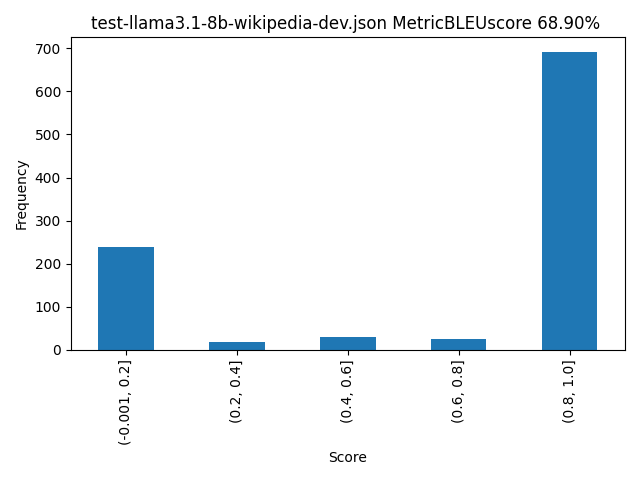

In [30]:
# Display Metrics from saved files
!pwd
!cat ./test/test-llama3.1-8b-wikipedia-dev-metrics.txt
!echo "................"

from IPython.display import Image
import base64

def read_b64_image_from_file(file_path):
  """Reads a base64 encoded image string from a file and decodes it."""

  with open(file_path, "r") as f:
    base64_string = f.read()

  # Decode the base64 string
  image_bytes = base64.b64decode(base64_string)
  return image_bytes

# Example usage
fname = "/content/for_step11_deploy/test/test-llama3.1-8b-wikipedia-dev-bar_plot.png"
with open(fname, "rb") as img_file:
    b64_bytes = base64.b64encode(img_file.read())
    b64_string = b64_bytes.decode('utf-8')

# Decode the base64 string
decoded_image = base64.b64decode(b64_string)

# Display the image
display(Image(data=decoded_image, format='png'))

In [34]:
# Try gemma2 model
%%time
!grep EVAR .env_gemma2

EVAR_VERBOSE=1
# EVAR_DATAPATH
EVAR_NUMQUES=1000
EVAR_MODELNAME=gemma2
EVAR_EVAL=1
EVAR_ISDOCKER=1
EVAR_FLASK_NGROK=0
CPU times: user 5.13 ms, sys: 0 ns, total: 5.13 ms
Wall time: 106 ms


In [35]:
%%time
!udocker --allow-root run --env-file=/content/for_step11_deploy/.env_gemma2 \
  -v=/content/for_step11_deploy:/target \
  -p 5000:5000 -p 53:53 my-llm-ollama-cont > output_app_log.txt 2>&1
clear_output()

CPU times: user 2.1 s, sys: 322 ms, total: 2.42 s
Wall time: 8min 8s


/content/for_step11_deploy
----------
Num qa: 1000, Got correct ans for 672 (67.20%) 
Average TimetoAnswer: 0.37sec. 
MetricBLEUscore 
(-0.001, 0.2]: 257
(0.2, 0.4]: 22
(0.4, 0.6]: 34
(0.6, 0.8]: 12
(0.8, 1.0]: 675
----------
................


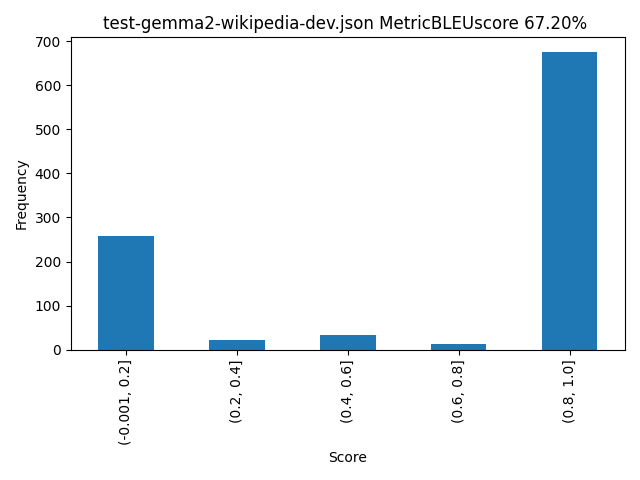

In [36]:
# Display Metrics from saved files
!pwd
!cat ./test/test-gemma2-wikipedia-dev-metrics.txt
!echo "................"

# Example usage
fname = "/content/for_step11_deploy/test/test-gemma2-wikipedia-dev-bar_plot.png"
with open(fname, "rb") as img_file:
    b64_bytes = base64.b64encode(img_file.read())
    b64_string = b64_bytes.decode('utf-8')

# Decode the base64 string
decoded_image = base64.b64decode(b64_string)

# Display the image
display(Image(data=decoded_image, format='png'))